Mounting drive where data is uploaded.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing the required libraries

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Activation,Conv2D, MaxPooling2D , LeakyReLU , Conv2DTranspose
from keras.layers import Dropout, BatchNormalization, UpSampling2D, Input, Concatenate
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model , Sequential, load_model
import warnings
warnings.simplefilter("ignore", UserWarning)
import tensorflow as tf

### Data loading and data preprocessing

In [3]:
mypath='/content/gdrive/MyDrive/DIV2K_train_LR_bicubic/X2'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
onlyfiles = onlyfiles[:400] # slice the list to keep only the first 400 elements
images = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
    images[n] = cv2.imread(join(mypath,onlyfiles[n]))

In [4]:
images.shape

(400,)

In [5]:
images[0].shape

(702, 1020, 3)

In [6]:
images[1].shape

(924, 1020, 3)

As dataset contains images of different sizes, padding images to convert them to same size

In [7]:
for i in range(images.shape[0]):
    resized_image = cv2.resize(images[i],(96,96))
    images[i] = resized_image

In [8]:
images = np.stack(images,axis=0)

In [9]:
images.shape

(400, 96, 96, 3)

In [10]:
clean_images = np.copy(images)

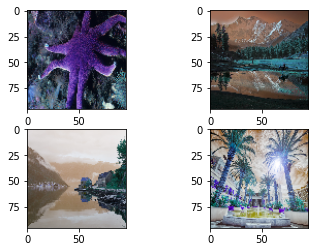

In [11]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(images[idx],cmap='gray')
        idx+=1

In [12]:
noisy_images = np.copy(images)
noisy_images2 = np.copy(images)

In [13]:
# Adding noise of standard deviation 25 to images
mean = 0
std = 25
for i in range(images.shape[0]):
    noise = np.random.randn(images[i].shape[0],images[i].shape[1],images[i].shape[2]) * std + mean
    noisy_image = images[i] + noise
    noisy_images[i] = noisy_image

In [14]:
# Adding noise of standard deviation 50 to images
mean = 0
std = 50
for i in range(images.shape[0]):
    noise2 = np.random.randn(images[i].shape[0], images[i].shape[1], images[i].shape[2]) * std + mean
    noisy_image2 = noisy_images2[i] + noise2
    noisy_images2[i] = noisy_image2

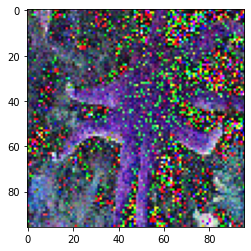

In [15]:
plt.imshow(noisy_images[0])

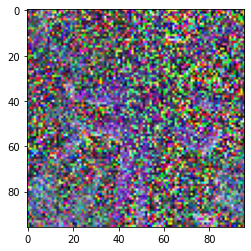

In [16]:
plt.imshow(noisy_images2[0])

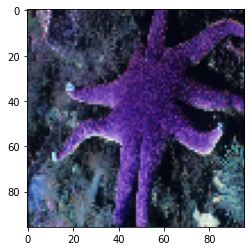

In [17]:
plt.imshow(clean_images[0])

The pixel data ranges from 0 to 255 hence dividing each pixel by 255,i.e,normalizing the data such that the range is within 0 to 1 and converting them to float32 to be used as tensor.

In [18]:
noisy_images.astype(np.float32)
clean_images.astype(np.float32)
noisy_images2.astype(np.float32)
noisy_images/255
clean_images/255
noisy_images2/255

array([[[[0.17647059, 0.25882353, 0.31764706],
         [0.3254902 , 0.54901961, 0.48627451],
         [0.23529412, 0.10980392, 0.87843137],
         ...,
         [0.36862745, 0.12941176, 0.71372549],
         [0.65098039, 0.29019608, 0.16078431],
         [0.03921569, 0.95294118, 0.13333333]],

        [[0.40392157, 0.18823529, 0.09803922],
         [0.43921569, 0.25882353, 0.70980392],
         [0.26666667, 0.10196078, 0.30588235],
         ...,
         [0.1372549 , 0.01568627, 0.3254902 ],
         [0.86666667, 0.63921569, 0.37254902],
         [0.99607843, 0.74117647, 0.22352941]],

        [[0.99215686, 0.62352941, 0.2745098 ],
         [0.30588235, 0.41568627, 0.95294118],
         [0.99215686, 0.08627451, 0.0745098 ],
         ...,
         [0.12941176, 0.8745098 , 0.01960784],
         [0.00392157, 0.        , 0.01176471],
         [0.91764706, 0.69019608, 0.27058824]],

        ...,

        [[0.54117647, 0.3372549 , 0.91372549],
         [0.40784314, 0.85882353, 0.38431373]

# Making Denoising GAN model


First making discriminator model

In [19]:
# Input layer
inputs = Input((96, 96, 3))

# First convolutional layer
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
x = LeakyReLU(alpha=0.01)(x)

# Second convolutional layer
x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)

# Third convolutional layer
x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.5)(x)

# Fourth convolutional layer
x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

# Output layer
#outputs = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
outputs = Dense(1,activation='sigmoid')(x)

# Creating the model
discriminator = Model(inputs, outputs)

In [20]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 12, 12, 128)       0     

Now making generator model

In [21]:
# Input layer
inputs = Input((96, 96, 3))

# Downsampling path
d1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
d2 = Conv2D(32, 3, activation='relu', padding='same')(d1)
d3 = MaxPooling2D()(d2)

d4 = Conv2D(64, 3, activation='relu', padding='same')(d3)
d5 = Conv2D(64, 3, activation='relu', padding='same')(d4)
d6 = MaxPooling2D()(d5)

d7 = Conv2D(128, 3, activation='relu', padding='same')(d6)
d8 = Conv2D(128, 3, activation='relu', padding='same')(d7)

# Upsampling path
u1 = UpSampling2D()(d8)
u2 = Concatenate()([u1, d5])
u3 = Conv2D(64, 3, activation='relu', padding='same')(u2)
u4 = Conv2D(64, 3, activation='relu', padding='same')(u3)

u5 = UpSampling2D()(u4)
u6 = Concatenate()([u5, d2])
u7 = Conv2D(32, 3, activation='relu', padding='same')(u6)
u8 = Conv2D(32, 3, activation='relu', padding='same')(u7)

# Output layer
outputs = Conv2D(3, 1, activation='sigmoid')(u8)

# Create the model
generator = Model(inputs, outputs)

In [22]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 96, 96, 32)   896         ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 96, 96, 32)   9248        ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 48, 32)   0           ['conv2d_5[0][0]']               
                                                                                            

# Training the generator and discriminator

In [23]:
# Preparing the data
noised_images = np.copy(noisy_images)
num_epochs = 100
batch_size = 400
save_interval = 5
g_losses = []
d_losses = []

In [24]:
# Compiling the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:

# Create a combined model for training the generator
input_noise = Input(shape=(96, 96, 3))
generated_image = generator(input_noise)
discriminator.trainable = False
validity = discriminator(generated_image)
combined = Model(input_noise, validity)
combined.compile(optimizer='adam', loss='binary_crossentropy')

# Train the generator and discriminator
with tf.device('/gpu:0'):
    for epoch in range(num_epochs):
        # Train the discriminator
        fake_images = generator.predict(noised_images)
        real_labels = np.ones(batch_size)
        fake_labels = np.zeros(batch_size)
        d_loss_real = discriminator.train_on_batch(clean_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_losses.append(d_loss)
        # Train the generator
        g_loss = combined.train_on_batch(noised_images, real_labels)
        g_losses.append(g_loss)
        # Print the losses
        print(f'epoch: {epoch+1}, discriminator loss: {d_loss}, generator loss: {g_loss}')

        #if (epoch+1) % save_interval == 0:
        #    discriminator.save(f'discriminator_epoch_{epoch+1}.h5')

13/13 [==============================] - 13s 956ms/step
epoch: 1, discriminator loss: 3.820602834224701, generator loss: 0.18022474646568298
13/13 [==============================] - 12s 955ms/step
epoch: 2, discriminator loss: 1.2119390964508057, generator loss: 0.0809704139828682
13/13 [==============================] - 12s 951ms/step
epoch: 3, discriminator loss: 1.3515684604644775, generator loss: 0.08811276406049728
13/13 [==============================] - 12s 951ms/step
epoch: 4, discriminator loss: 1.159157633781433, generator loss: 0.1533079892396927
13/13 [==============================] - 12s 944ms/step
epoch: 5, discriminator loss: 0.8508984446525574, generator loss: 0.2918144464492798
13/13 [==============================] - 13s 1000ms/step
epoch: 6, discriminator loss: 0.5779531598091125, generator loss: 0.48767393827438354
13/13 [==============================] - 12s 950ms/step
epoch: 7, discriminator loss: 0.41829875111579895, generator loss: 0.6235762238502502
13/13 [===

In [ ]:

# Plot the loss values
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.legend()
plt.show()

# TESTING THE DENOISING GAN


In [ ]:
mypath='/content/gdrive/MyDrive/DIV2K_valid_LR_bicubic_X2/DIV2K_valid_LR_bicubic/X2'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
test_images = np.empty(len(onlyfiles), dtype=object)
for n in range(0,len(onlyfiles)):
    test_images[n] = cv2.imread(join(mypath,onlyfiles[n]))

In [ ]:
test_images.shape

In [ ]:
test_images[0].shape

In [ ]:
test_images[1].shape

As dataset contains images of different sizes, padding images to convert them to same size

In [ ]:
for i in range(test_images.shape[0]):
    resized_image = cv2.resize(test_images[i],(96,96))
    test_images[i] = resized_image

In [ ]:
test_images = np.stack(test_images,axis=0)

In [ ]:
test_images.shape

In [ ]:
noised_test_images = np.copy(test_images)
noised_test_images2 = np.copy(test_images)

In [ ]:
# Adding noise of standard deviation 25 to images
mean = 0
std = 5
for i in range(test_images.shape[0]):
    noise = np.random.randn(test_images[i].shape[0],test_images[i].shape[1],test_images[i].shape[2]) * std + mean
    noisy_test_images = test_images[i] + noise
    noised_test_images[i] = noisy_test_images

In [ ]:
# Function to calculate SSIM
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid offset
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim.mean()

# Function to calculate PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))


In [ ]:
denoised_test_images = generator.predict(noised_test_images)

In [ ]:
denoised_test_images.astype(np.float32)
denoised_test_images/255

In [ ]:
# Showing the grount truth, noised, and denoised images for comparison
for i in range(6):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title("Ground Truth")
    plt.subplot(1, 3, 2)
    plt.imshow(noised_test_images[i])
    plt.title("Noised Image")
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_test_images[i])
    plt.title("Denoised Image")
    plt.show()

In [ ]:
# Evaluating the performance of the generator on the test images
ssim_scores = []
psnr_scores = []
mse_scores = []
for i in range(len(test_images)):
    ssim_scores.append(ssim(test_images[i], denoised_test_images[i]))
    psnr_scores.append(psnr(test_images[i], denoised_test_images[i]))
    mse_scores.append(np.mean((test_images[i] - denoised_test_images[i]) ** 2))

In [ ]:
# Printing the average SSIM, PSNR, and MSE scores
print(f'Average SSIM: {np.mean(ssim_scores)}')
print(f'Average PSNR: {np.mean(psnr_scores)}')
print(f'Average MSE: {np.mean(mse_scores)}')

In [ ]:
# Ploting the average PSNR, and MSE scores for all test images
plt.plot(psnr_scores, label='PSNR')
plt.plot(mse_scores, label ='MSE')
plt.legend()
plt.show()